In [23]:
import requests 
import numpy as np
from bs4 import BeautifulSoup 
import pandas as pd
import re
import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json

In [24]:

def scrape_table(url):
    # Creating soup for each source
    soup = BeautifulSoup(requests.get(url).content, 'lxml')

    # Getting rows for each table from soup
    table_rows = soup.find_all('tr')
    
    # Getting column names given as the 'th' tag; strip=True means that the tags are removed from the string
    column_names = []
    for cell in table_rows[0].find_all('th'):
        column_names.append(cell.get_text(strip=True))

    # Getting cell data in list to later create a DataFrame
    each_row = []
    for row in table_rows[1:]:
        each_row.append([cell.get_text(strip=True) for cell in row.find_all('td')])

    # Creating DataFrame from extracted data
    df = pd.DataFrame(each_row, columns=column_names)
    
    return df

def clean_data(df):
    
    # Checking for which dataframe is recieved 
    if 'Name of State / UT' in df:
        df = india_df.iloc[:33, :]
        df.drop('S. No.', axis=1, inplace=True)
        df.set_index('Name of State / UT', inplace=True)
        for col in df.columns:
            df[col] = df[col].str.extract('(\d+)').astype(int)
        df.sort_values(df.columns[0], ascending=False, inplace=True)
        
        # Creating recovery_rate to understand more about the closed cases
        df['recovery_rate (in percentage)'] = ((df[df.columns[1]]/(df[df.columns[1]]+df[df.columns[2]]))*100).round(2)
        
        # No idea why this isnt working
#        df.rename(columns={df.columns[1]:'Total Cases',
#                        df.columns[3]:'Deaths', 
#                        df.columns[2]:'Total Recovered'}, 
#                  inplace=True)
#        response = requests.get("https://api.covid19india.org/state_test_data.json")
#        data = json.loads(response.text)
#        data1 = data.get('states_tested_data')
#        df['ICU Beds'] = 0
#        df['Isolation Beds'] = 0
#        df['Total Tests'] = 0
#        df['Test positive rate'] = 0
#        for x in data1:
#            if x.get('state') in df[df.columns[0]].values:
#                if x.get('testpositivityrate') != '':
#                    df.loc[temp_df[df.columns[0]]==x.get('state'), 'Test positive rate'] = float(x.get('testpositivityrate')[:-1])
#                if x.get('totaltested') != '':
#                    df.loc[temp_df[df.columns[0]]==x.get('state'), 'Total Tests'] = float(x.get('totaltested'))
#                if x.get('numicubeds') != '':
#                    df.loc[temp_df[df.columns[0]]==x.get('state'), 'ICU Beds'] = int(x.get('numicubeds'))
#                if x.get('numisolationbeds') != '':
#                    df.loc[temp_df[df.columns[0]]==x.get('state'), 'Isolation Beds'] = int(x.get('numisolationbeds'))
    
    elif 'TotalDeaths' in df:
        # The reason for not hard coding here below is that
        # The website might add on later new countires whose data might not be available now
        upper_index = world_df[world_df['Country,Other']=='World'].index[0]
        lower_index = world_df[world_df['Country,Other']=='Total:'].index[0]
        
        # 15 May, website updated their table and added a number column
        world_df.drop('#', axis=1, inplace=True)
        
        # Dropping columns after active cases, this can be changed depending on need for analysis later on
        df = world_df.iloc[upper_index:lower_index, :-7]
        df['Total Tests'] = world_df.loc[:, 'TotalTests'].iloc[upper_index:lower_index]
        df.set_index('Country,Other', inplace=True)
        
        # Converting alphanumeric data to pure numeric and later to integer type
        # this works for all values
        for col in df.columns:
            df[col] = [''.join(re.findall(r'\d+', df[col].values[i])) for i in range(len(df[col]))]
            df[col] = df[col].replace('', 0)
            df[col] = df[col].apply(int)
            
        df.sort_values('TotalCases', ascending=False, inplace=True)
        df['recovery_rate (in percentage)'] = ((df[df.columns[4]]/(df[df.columns[4]]+df[df.columns[2]]))*100).round(2)
        df['Positive Rate'] = ((df['TotalCases']/df['Total Tests'])*100).round(2)
        df['Positive Rate'].replace(np.inf, 0, inplace=True)
    
    return df

india_url = 'https://www.mohfw.gov.in/'
india_df = scrape_table(india_url)
world_url = 'https://www.worldometers.info/coronavirus/'
world_df = scrape_table(world_url)

india_df_clean = clean_data(india_df)
world_df_clean = clean_data(world_df)



##### A time series analysis would be good considering the trend and what is expected if the trend continues for a few months
##### Developing a machine learning model based on https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset dataset having features such as (symptoms, date of hospitalization, date of first symptom, gender, age) and label such as (recovered, death)
Or analysis based on the corelation on the above dataset

In [25]:
india_df_clean

,Active Cases*,Cured/Discharged/Migrated*,Deaths**,Total Confirmed cases*,recovery_rate (in percentage)
Name of State / UT,,,,,
Maharashtra,67615,84245,7273,159133,92.05
Tamil Nadu,33216,44094,1025,78335,97.73
Delhi,28329,49301,2558,80188,95.07
Telangana,8265,4928,243,13436,95.30
Andhra Pradesh,6648,5480,157,12285,97.21
Gujarat,6511,22409,1789,30709,92.61
Haryana,4737,8472,218,13427,97.49
Karnataka,4445,7287,191,11923,97.45
Rajasthan,3186,13367,391,16944,97.16


In [26]:
#world_df_clean.drop('#', axis=1, inplace=True)
world_df_clean

,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,Total Tests,recovery_rate (in percentage),Positive Rate
"Country,Other",,,,,,,,,,,,,
World,10118952,43837,501960,1336,5487442,32894,4129550,57867,1298,644,0,91.62,0.00
USA,2596894,357,128153,1,1081494,57,1387247,15816,7846,387,32000928,89.41,8.12
Brazil,1319274,3333,57149,46,715905,0,546220,8318,6207,269,2925935,92.61,45.09
Russia,634437,6791,9073,104,399087,5735,226277,2300,4347,62,19044954,97.78,3.33
India,530997,1420,16128,25,311364,1218,203505,8944,385,12,8227802,95.08,6.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
British Virgin Islands,8,0,1,0,7,0,0,0,265,33,212,87.50,3.77
Caribbean Netherlands,7,0,0,0,7,0,0,0,267,0,424,100.00,1.65
St. Barth,6,0,0,0,6,0,0,0,607,0,152,100.00,3.95


<hr>

# Appending week 2 here on

##### Currently not using time series, for future reference when working on world data for applying ML
<code>
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
</code>

In [27]:
temp_df = india_df_clean.reset_index()
temp_df1 =world_df_clean.reset_index()

#Adding Positive Rate 
#temp_df1['Positive Rate'] = ((temp_df1['TotalCases']/temp_df1['Total Tests'])*100).round(2)
#temp_df1.replace(np.inf, 0, inplace=True)


temp_df.rename(columns={temp_df.columns[1]:'Total Cases',
                        temp_df.columns[3]:'Deaths', 
                        temp_df.columns[2]:'Total Recovered'}, 
               inplace=True)
response = requests.get("https://api.covid19india.org/state_test_data.json")
data = json.loads(response.text)
data1 = data.get('states_tested_data')
temp_df['ICU Beds'] = 0
temp_df['Isolation Beds'] = 0
temp_df['Total Tests'] = 0
temp_df['Test positive rate'] = 0
for x in data1:
    if x.get('state') in temp_df[temp_df.columns[0]].values:
        if x.get('testpositivityrate') != '':
            temp_df.loc[temp_df[temp_df.columns[0]]==x.get('state'), 'Test positive rate'] = float(x.get('testpositivityrate')[:-1])
        if x.get('totaltested') != '':
            temp_df.loc[temp_df[temp_df.columns[0]]==x.get('state'), 'Total Tests'] = float(x.get('totaltested'))
        if x.get('numicubeds') != '':
            temp_df.loc[temp_df[temp_df.columns[0]]==x.get('state'), 'ICU Beds'] = int(x.get('numicubeds'))
        if x.get('numisolationbeds') != '':
            temp_df.loc[temp_df[temp_df.columns[0]]==x.get('state'), 'Isolation Beds'] = int(x.get('numisolationbeds'))


In [28]:
total_cases_india = temp_df.columns[1]
total_recovered_india = temp_df.columns[2]
deaths_india = temp_df.columns[3]
total_tests_india = temp_df.columns[8]
positive_rate_india = temp_df.columns[9]

total_cases_world = temp_df1.columns[1]
total_recovered_world = temp_df1.columns[5]
deaths_world = temp_df1.columns[3]
total_tests_world = temp_df1.columns[7]
positive_rate_world = temp_df1.columns[9]

In [29]:
def bar_chart(df, x, y, category):
    
    title = f'{x}({y}) ' + category
        
    fig = px.bar(df, x=df.columns[0], y=df[x], 
                 title = title, 
                 color = df[y],
                 template = 'plotly_dark') 
    #           width=800, height=400)

    fig.update_layout(title={'x':0.5,
                             'xanchor':'center'},
                      hovermode='x')

    fig.update_xaxes(tickangle=-45)

    #fig.write_image(f'{title}.png')
    
    return fig.show()#renderer="svg", height = 500, width = 1000)

def pie_chart(df, x, y, category):
    title = f'{x} and {y} ' + category

    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
    fig.add_trace(go.Pie(labels=df[df.columns[0]], values=df[x], name=x),
                  1, 1)
    fig.add_trace(go.Pie(labels=df[df.columns[0]], values=df[y], name=y),
                  1, 2)

    fig.update_traces(hole=0.3, textposition='inside', textinfo='percent+label', showlegend=True)
    fig.update_layout(title={'x':0.5,
                             'xanchor':'center'},
                      title_text = title, 
                      annotations=[dict(text=x, x=0.16, y=0.5, font_size=13, showarrow=False),
                                   dict(text=y, x=0.825, y=0.5, font_size=15, showarrow=False)], 
                      hovermode='x')

    #fig.write_image(f'{title}.png')

    return fig.show()#renderer="svg", height = 1000, width = 1000)

In [30]:
bar_chart(temp_df, total_cases_india, deaths_india, 'India')

From the above visualization we can infer that although Total Cases in Tamil Nadu and Delhi is close to Gujrat, the deaths in Gujrat is significantly more<br>
Hence **Gujrat must not neglect lockdown measures and concentrate on better medical fascilities**

In [31]:
bar_chart(temp_df1.iloc[2:22, :], total_cases_world, deaths_world, 'World')

From the above graph we can easily say <br>
<ul>
    <li>Russia has great medical fascilites considering it is between Spain and UK who are doing considerably worse having more number of total deaths</li>
    <li>Belgium does not look ready for the epidemic considering the neighbouring countries</li>
</ul>

In [32]:
pie_chart(temp_df, total_cases_india, deaths_india, 'India')

The above visualization is made self explainatory <br>
Interacting with plot to remove the highest contributor of pie for both charts at the same time readjusts it showing the remaining contributors<br>
We can see here as well that Gujrat is contributing 12.2% in India's Total Cases and 22.3% in India's Total Deaths due to coronavirus<br>
Hence **Gujrat must not take the lockdown liniently**

In [33]:
pie_chart(temp_df1.iloc[2:22, :], total_cases_world, deaths_world, 'World')

The above graph is about the top 20 countries and we can see each countries part out of the top countries for the given category<br>
**India's contribution is the exact value of pie in Total Cases**

In [34]:
bar_chart(temp_df, total_recovered_india, total_cases_india, 'India')


From the above graph we can observe while comparing Rajasthan, Delhi and Tamil Nadu<br>
Rajasthan has cured more people while having more cases than Delhi and Tamil Nadu<br>
From this we can infer that **Rajasthan has better medical fascilities**


In [35]:
bar_chart(temp_df1.iloc[2:22, :], total_recovered_world, total_cases_world, 'World')

Number of people recovered for some countries such as UK and Netherlands was not uploaded hence it is 0<br>

<code>
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_df = confirmed[confirmed['Country/Region'] == 'India'].iloc[:, 4:].T.reset_index()
confirmed_df['Date'] = pd.DatetimeIndex(confirmed_df['index'])
confirmed_df.rename(columns={131:'India'}, inplace=True)
########confirmed_df.drop('index', axis=1, inplace=True)
fig = px.scatter(confirmed_df, x=range(len(confirmed_df)), y='India', title='Trend Line', trendline='lowess')
fig.update_xaxes(ticktext=confirmed_df[confirmed_df.columns[2]].values.astype(str), 
                 tickvals=np.arange(len(confirmed_df)),
                 showticklabels=True)
fig.show()
</code>

The above code displays the following graph which currently isnt helpful as it uses trendline='lowess' #can replace 'lowess' with 'ols'<br>LOWESS = (locally weighted scatterplot smoothing) <a> href="https://en.wikipedia.org/wiki/Local_regression" > Link for better understanding</a><br>OLS = (Ordinary Least Squared)<br>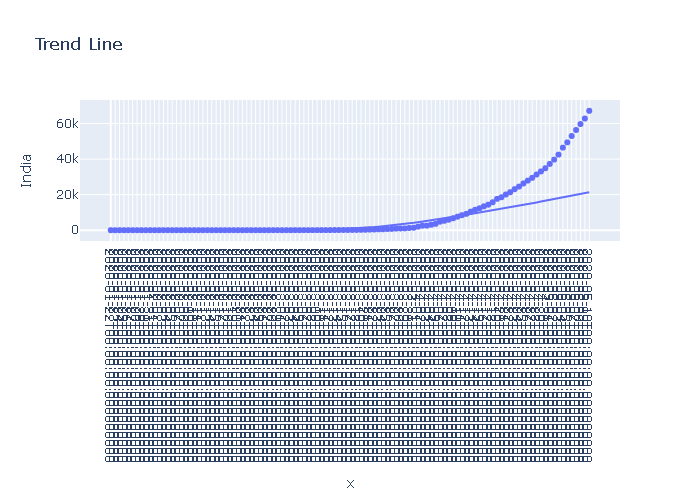<br>As we can see LOWESS needs larger amount of data for a better model<br>Also I need help with making this graph better since I'm restricted for using
<ol>
<li><code>x=range(len(confirmed_df))</code>in <code>px.scatter</code> since it wont otherwise give the trendline and </li>
<li><code>ticktext=confirmed_df[confirmed_df.columns[2]].values.astype(str)</code>in <code>fig.update_xaxes</code> for actually displaying dates on x axis and converted to string because otherwise a huge int/float is displayed on the x axis</li>
</ol>

In [36]:
bar_chart(temp_df, positive_rate_india, total_tests_india, 'India')

From the above graph we can infer 
<ul>
    <li>Chandigarh must conduct more tests to ensure curbing the spread of Coronavirus</li>
    <li>Tamil Nadu is doing excellent considering they have the highest tests done and significantly low test positivity rate</li>
    <li>Andhra Pradesh is also doing well considering few tests turning out positive and considerably high total tests</li>
</ul>

In [37]:
bar_chart(temp_df1.iloc[2:22, :], positive_rate_world, total_tests_world, 'World')

<ul>
    <li>Russia is very low on patients tested positive and they have conducted the maximum tests</li>
    <li>Brazil is testing positive tremendously high and have conducted minimum number of tests</li>
</ul>

<hr>
<ul>
    <li>I have omited the use of total beds as there is no updated info for many states </li>
    <li>Similarly I have avoided gender and age since available data is not officially provided</li>
</ul>

In [38]:
# Trying to see if making a plot to interpret 3 variables is possible

variable_1 = positive_rate_india
variable_2 = total_recovered_india
variable_3 = deaths_india

fig = px.scatter_3d(data_frame=temp_df, 
              x=temp_df.columns[0], y=temp_df[variable_1], z=temp_df[variable_2], 
              color=temp_df[variable_3], title = f'{variable_1}({variable_2}({variable_3}))', 
              template = 'plotly_dark')
fig.show()
#plotly.offline.plot(fig)

In [39]:
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_df = confirmed[confirmed['Country/Region'] == 'India'].iloc[:, 4:].T.reset_index()
deaths_df = deaths[deaths['Country/Region'] == 'India'].iloc[:, 4:].T.reset_index()
recovered_df = recovered[recovered['Country/Region'] == 'India'].iloc[:, 4:].T.reset_index()

confirmed_df['Date'] = pd.DatetimeIndex(confirmed_df['index'])
deaths_df['Date'] = pd.DatetimeIndex(deaths_df['index'])
recovered_df['Date'] = pd.DatetimeIndex(recovered_df['index'])

confirmed_df.rename(columns={confirmed_df.columns[1]:'Confirmed'}, inplace=True)
confirmed_df.drop('index', axis=1, inplace=True)
deaths_df.rename(columns={deaths_df.columns[1]:'Deaths'}, inplace=True)
deaths_df.drop('index', axis=1, inplace=True)
recovered_df.rename(columns={recovered_df.columns[1]:'Recovered'}, inplace=True)
recovered_df.drop('index', axis=1, inplace=True)
recovered_df
deaths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Deaths  158 non-null    int64         
 1   Date    158 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.6 KB


In [40]:
daily_deaths = []
for i in range(deaths_df.shape[0]):
    if i == 0:
        daily_deaths.append(0)
    else:
        daily_deaths.append(deaths_df.iloc[i]['Deaths'] - deaths_df.iloc[i-1]['Deaths'])
        #print(deaths_df.iloc[i]['Deaths'])
    #print(i)
print(len(daily_deaths))
print(deaths_df.shape)
deaths_df.insert(2, "Daily Deaths", daily_deaths, True)
;

158
(158, 2)


''

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=confirmed_df['Date'], y=confirmed_df['Confirmed'],mode='lines',name='Confirmed'))
fig.add_trace(go.Scatter(x=deaths_df['Date'], y=deaths_df['Deaths'],mode='lines',name='Deaths'))
fig.add_trace(go.Scatter(x=recovered_df['Date'], y=recovered_df['Recovered'],mode='lines',name='Recovered'))
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [42]:
ma = 3
deaths_df['MA'] = deaths_df['Daily Deaths'].rolling(ma).mean()
deaths_df['MA'].fillna(0, inplace=True)

fig = go.Figure([go.Bar(x=deaths_df['Date'], y=deaths_df['Daily Deaths'], name='Daily Deaths')])
fig.add_trace(go.Scatter(x=deaths_df['Date'], y=deaths_df['MA'],mode='lines',name=f'moving average of {ma}'))
fig.update_layout(hovermode='x')
fig.show()
#px.bar(deaths_df, x='Date', y='Daily Deaths')

In [43]:
world_daily_deaths = pd.DataFrame(deaths.iloc[:, 4:].sum(), columns=["deaths"])
world_daily_deaths["Daily"] = 0
for i in range(world_daily_deaths.shape[0]):
    if i == 0:
        world_daily_deaths["Daily"].iloc[i] = world_daily_deaths['deaths'].iloc[i]
    else:
        world_daily_deaths["Daily"].iloc[i] = world_daily_deaths['deaths'].iloc[i] - world_daily_deaths['deaths'].iloc[i-1]
world_daily_deaths["Date"] = pd.DatetimeIndex(world_daily_deaths.index)
world_daily_deaths

,deaths,Daily,Date
1/22/20,17,17,2020-01-22
1/23/20,18,1,2020-01-23
1/24/20,26,8,2020-01-24
1/25/20,42,16,2020-01-25
1/26/20,56,14,2020-01-26
...,...,...,...
6/23/20,477587,5416,2020-06-23
6/24/20,482758,5171,2020-06-24
6/25/20,489312,6554,2020-06-25
6/26/20,494181,4869,2020-06-26


In [44]:
ma = 5
world_daily_deaths['MA'] = world_daily_deaths['Daily'].rolling(ma).mean()
world_daily_deaths['MA'].fillna(0, inplace=True)

fig = go.Figure([go.Bar(x=world_daily_deaths["Date"], y=world_daily_deaths['Daily'], name='Daily Deaths')])
fig.add_trace(go.Scatter(x=world_daily_deaths["Date"], y=world_daily_deaths['MA'],mode='lines',name=f'moving average of {ma}'))
fig.update_layout(hovermode='x')
fig.show()